In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
model_name_or_path = 'meta-llama/Llama-2-7b-chat-hf'

print('Loading model...')
#load the model in 16 bit precision
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map="auto", torch_dtype=torch.float16)

print(model.device)

print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, padding_side="left")
tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.unk_token

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

cuda:0
Loading tokenizer...


In [3]:
dataset = load_dataset("rotten_tomatoes")
#convert to dataframe
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])
df_val = pd.DataFrame(dataset['validation'])
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

df_train.head()

(8530, 2)
(1066, 2)
(1066, 2)


,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


In [61]:
template1 = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(A) Negative
(B) Positive

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels1 = ['A', 'B']

template2 = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(A) Positive
(B) Negative

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels2 = ['B', 'A']

template3 = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(B) Positive
(A) Negative

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels3 = ['A', 'B']

template4 = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(B) Negative
(A) Positive

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels4 = ['B', 'A']

A_index = tokenizer.convert_tokens_to_ids('A')
B_index = tokenizer.convert_tokens_to_ids('B')

In [5]:
def filtration(df, template, Labels):

    batch_size = 64
    num_batches = len(df) // batch_size + 1

    for batch_idx in tqdm(range(num_batches)):

        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        prompts = [template.format(comment=row['text']) for _, row in batch_df.iterrows()]
        tokens = tokenizer.batch_encode_plus(prompts, return_tensors='pt', padding=True, truncation=False).to(device=model.device)

        with torch.no_grad():
            # print('tokens: ', tokens['input_ids'])
            # print('attention mask: ', tokens['attention_mask'])
            output = model(tokens['input_ids'], attention_mask=tokens['attention_mask'])
            
            logits = output.logits

            for i in range(logits.shape[0]):
                #get the logits for the last token
                current_logits = logits[i, -1, :]
                #get the most likely token
                most_likely_token_index = torch.argmax(current_logits).item()
                most_likely = tokenizer.convert_ids_to_tokens([most_likely_token_index])[0]

                #neither A nor B are the most likely token
                if most_likely != 'A' and most_likely != 'B':
                    print('Unexpected token: ', most_likely)
                    print('prompt: ', batch_df.iloc[i]['text'])
                    df.loc[start_idx+i,'correct'] = 0

                else:
                    A_B_logits = current_logits[[A_index, B_index]]                
                    A_B_logits = torch.softmax(A_B_logits, dim=0)
                    A_certainty = A_B_logits[0].item()
                    B_certainty = A_B_logits[1].item()
                    if Labels[batch_df.iloc[i]['label']] == 'A':
                        certainty = A_certainty
                    elif Labels[batch_df.iloc[i]['label']] == 'B':
                        certainty = B_certainty
                    df.loc[start_idx+i,'correct'] = certainty

                # if i==batch_size-1:
                #     print("COMPLETE OUTPUT ##############################################################################################")
                #     answers = model.generate(tokens['input_ids'], attention_mask=tokens['attention_mask'], max_length=200, do_sample=False)
                #     decoded_answers = tokenizer.batch_decode(answers, skip_special_tokens=False)
                #     for index, el in enumerate(decoded_answers):
                #         print(el)                          
                #     raise Exception('stop')

                # if batch_idx >= 1 and batch_df.iloc[i]['label'] == 0 and most_likely == 'B':
                #     print('df index', start_idx+i)
                #     print('text: ', batch_df.iloc[i]['text'])
                #     print('label: ', batch_df.iloc[i]['label'])
                #     print('most likely: ', most_likely)

                #     print(torch.topk(current_logits, 5).indices)
                #     print('top 10 tokens: ', tokenizer.convert_ids_to_tokens(torch.topk(current_logits, 10).indices.tolist()))
                #     print('top 10 logits: ', torch.topk(current_logits, 10).values.tolist())
                #     print('A_B_logits: ', current_logits[[A_index, B_index]])
                #     print('A_B_logits softmax: ', A_B_logits)
                #     raise Exception('stop')
            
            #release memory
        torch.cuda.empty_cache()

In [75]:
def plot_certainty(df, template):

    positive_accuray = round((df[df['label'] == 1]['correct'] > 0.5).sum() / len(df[df['label'] == 1]) *100)
    negative_accuracy = round((df[df['label'] == 0]['correct'] > 0.5).sum() / len(df[df['label'] == 0]) *100)

    df_plot = df.copy()
    # Change labels values from 0 to Negative and 1 to Positive
    df_plot['label'] = df_plot['label'].apply(lambda x: 'Negative' if x==0 else 'Positive')
    # Get the distribution of the certainty scores in a sns kde plot, have a different color for different labels, use this color palete: (#1c93c9) and (#c9981c)
    g = sns.kdeplot(data=df_plot, x='correct', hue='label', palette=['green', 'red'], common_norm=False, fill=True, alpha=0.5, linewidth=1, clip=(0,1))
    # g = sns.kdeplot(data=df_plot, x='correct', hue='label', palette=['#1c93c9', '#c9981c'], common_norm=False, fill=True, alpha=0.5, linewidth=0)


    # Get the legend object
    legend = g.get_legend()
    # Set the title of the legend
    legend.set_title('Ground truth sentiment')
    # Force the legend to be in the upper left corner
    legend._loc = 2

    # Draw a vertical line at 0.5
    plt.axvline(x=0.5, color='black', linestyle='--')
    plt.xlabel('Confidence Score')
    #limit the x axis to 0 and 1
    plt.xlim(0, 1)
    # Add caption
    caption = 'Accuracy for positive sentiment: ' + str(positive_accuray) + '%\nAccuracy for negative sentiment: ' + str(negative_accuracy) + '%\n\n'
    caption = caption + template.replace('[INST]','Human:').replace('[/INST]', 'Assistant:').replace('comment', 'snippet')
    plt.figtext(0.5, -0.35, caption, wrap=True, horizontalalignment='center', fontsize=10)
    # Set title
    plt.title('Distribution of Confidence Scores')

    # Show the plot
    plt.show()

In [7]:
df_train['correct'] = np.nan
df_train['Split'] = 'train'
filtration(df_train, template1, Labels1)
df_test['correct'] = np.nan
df_test['Split'] = 'test'
filtration(df_test, template1, Labels1)
df_val['correct'] = np.nan
df_val['Split'] = 'validation'
filtration(df_val, template1, Labels1)

df_1 = pd.concat([df_train, df_test, df_val])

 23%|██▎       | 31/134 [00:34<01:55,  1.12s/it]

Unexpected token:  <unk>
prompt:  en sí mismo el rey león es un espectáculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal .


 49%|████▊     | 65/134 [01:11<01:13,  1.07s/it]

Unexpected token:  <unk>
prompt:  the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds .


 94%|█████████▍| 16/17 [00:17<00:01,  1.12s/it]

Unexpected token:  <unk>
prompt:  . . . blade ii is still top-heavy with blazing guns , cheatfully filmed martial arts , disintegrating bloodsucker computer effects and jagged camera moves that serve no other purpose than to call attention to themselves .


100%|██████████| 17/17 [00:18<00:00,  1.09s/it]


In [8]:
df_train['correct'] = np.nan
df_train['Split'] = 'train'
filtration(df_train, template2, Labels2)
df_test['correct'] = np.nan
df_test['Split'] = 'test'
filtration(df_test, template2, Labels2)
df_val['correct'] = np.nan
df_val['Split'] = 'validation'
filtration(df_val, template2, Labels2)

df_2 = pd.concat([df_train, df_test, df_val])

 23%|██▎       | 31/134 [00:34<01:57,  1.15s/it]

Unexpected token:  <unk>
prompt:  en sí mismo el rey león es un espectáculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal .


 49%|████▊     | 65/134 [01:12<01:14,  1.08s/it]

Unexpected token:  <unk>
prompt:  the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds .


 94%|█████████▍| 16/17 [00:17<00:01,  1.12s/it]

Unexpected token:  <unk>
prompt:  . . . blade ii is still top-heavy with blazing guns , cheatfully filmed martial arts , disintegrating bloodsucker computer effects and jagged camera moves that serve no other purpose than to call attention to themselves .


100%|██████████| 17/17 [00:18<00:00,  1.09s/it]


In [11]:
df_train['correct'] = np.nan
df_train['Split'] = 'train'
filtration(df_train, template3, Labels3)
df_test['correct'] = np.nan
df_test['Split'] = 'test'
filtration(df_test, template3, Labels3)
df_val['correct'] = np.nan
df_val['Split'] = 'validation'
filtration(df_val, template3, Labels3)

df_3 = pd.concat([df_train, df_test, df_val])

 23%|██▎       | 31/134 [00:34<01:58,  1.15s/it]

Unexpected token:  <unk>
prompt:  en sí mismo el rey león es un espectáculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal .


 49%|████▊     | 65/134 [01:12<01:14,  1.08s/it]

Unexpected token:  <unk>
prompt:  the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds .


 65%|██████▍   | 11/17 [00:12<00:06,  1.15s/it]

Unexpected token:  <unk>
prompt:  when [reno] lets her radical flag fly , taking angry potshots at george w . bush , henry kissinger , larry king , et al . , reno devolves into a laugh-free lecture .


 94%|█████████▍| 16/17 [00:18<00:01,  1.13s/it]

Unexpected token:  <unk>
prompt:  . . . blade ii is still top-heavy with blazing guns , cheatfully filmed martial arts , disintegrating bloodsucker computer effects and jagged camera moves that serve no other purpose than to call attention to themselves .


100%|██████████| 17/17 [00:18<00:00,  1.10s/it]


In [12]:
df_train['correct'] = np.nan
df_train['Split'] = 'train'
filtration(df_train, template4, Labels4)
df_test['correct'] = np.nan
df_test['Split'] = 'test'
filtration(df_test, template4, Labels4)
df_val['correct'] = np.nan
df_val['Split'] = 'validation'
filtration(df_val, template4, Labels4)

df_4 = pd.concat([df_train, df_test, df_val])

 23%|██▎       | 31/134 [00:34<01:57,  1.15s/it]

Unexpected token:  <unk>
prompt:  en sí mismo el rey león es un espectáculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal .


 49%|████▊     | 65/134 [01:12<01:14,  1.08s/it]

Unexpected token:  <unk>
prompt:  the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds .


 65%|██████▍   | 11/17 [00:12<00:06,  1.15s/it]

Unexpected token:  <unk>
prompt:  when [reno] lets her radical flag fly , taking angry potshots at george w . bush , henry kissinger , larry king , et al . , reno devolves into a laugh-free lecture .


 94%|█████████▍| 16/17 [00:17<00:01,  1.12s/it]

Unexpected token:  <unk>
prompt:  . . . blade ii is still top-heavy with blazing guns , cheatfully filmed martial arts , disintegrating bloodsucker computer effects and jagged camera moves that serve no other purpose than to call attention to themselves .


100%|██████████| 17/17 [00:18<00:00,  1.09s/it]


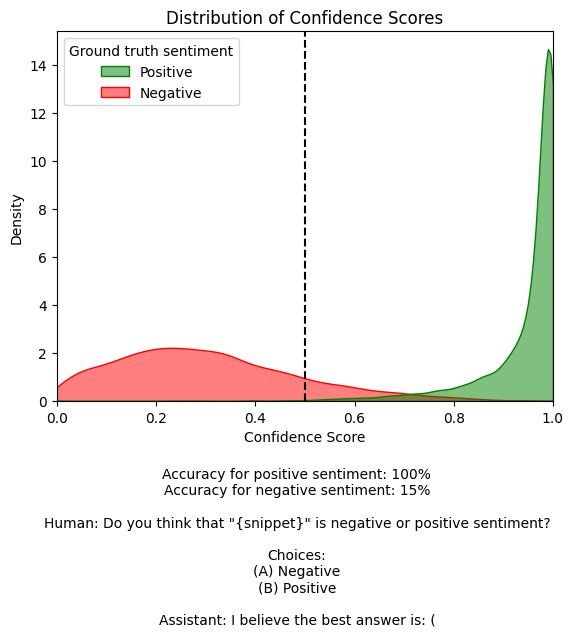

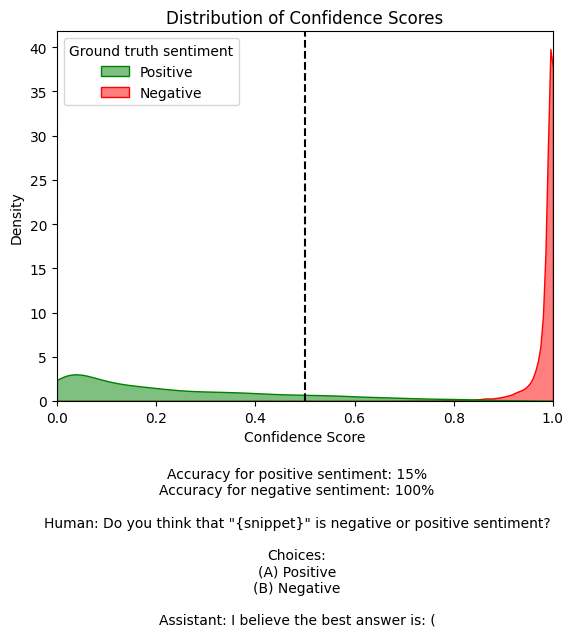

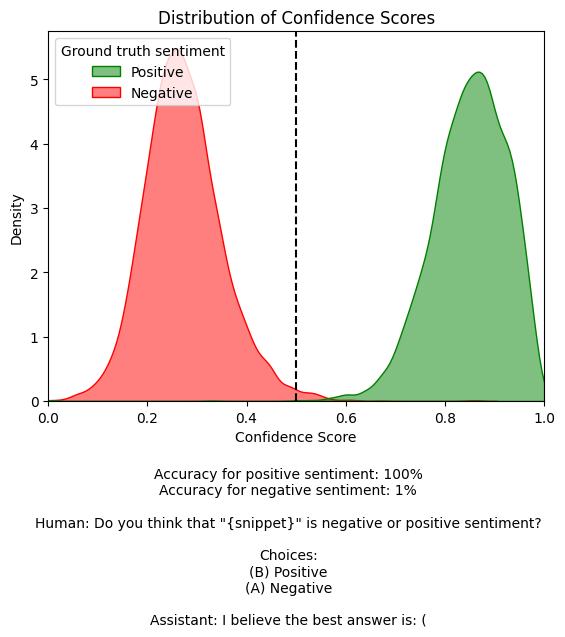

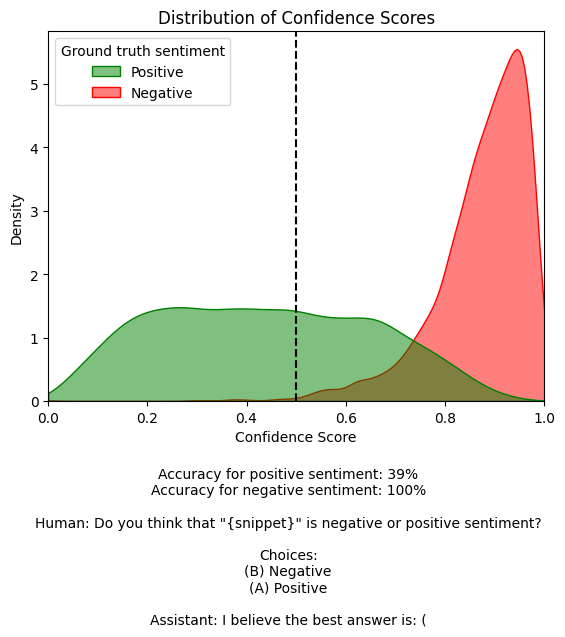

In [76]:
plot_certainty(df_1, template1)
plot_certainty(df_2, template2)
plot_certainty(df_3, template3)
plot_certainty(df_4, template4)

In [45]:
template_final = '''[INST] Do you think that "{comment}” is negative or positive sentiment?

Choices:
(P) Positive
(N) Negative

[/INST] I believe the best answer is: ('''

#note: in the rotten tomatoes dataset, 0 is negative and 1 is positive
Labels_final = ['N', 'P']

N_index = tokenizer.convert_tokens_to_ids('N')
P_index = tokenizer.convert_tokens_to_ids('P')

In [46]:
def filtration_final(df, template, Labels):

    batch_size = 64
    num_batches = len(df) // batch_size + 1

    for batch_idx in tqdm(range(num_batches)):

        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]

        prompts = [template.format(comment=row['text']) for _, row in batch_df.iterrows()]
        tokens = tokenizer.batch_encode_plus(prompts, return_tensors='pt', padding=True, truncation=False).to(device=model.device)

        with torch.no_grad():
            # print('tokens: ', tokens['input_ids'])
            # print('attention mask: ', tokens['attention_mask'])
            output = model(tokens['input_ids'], attention_mask=tokens['attention_mask'])
            
            logits = output.logits

            for i in range(logits.shape[0]):
                #get the logits for the last token
                current_logits = logits[i, -1, :]
                #get the most likely token
                most_likely_token_index = torch.argmax(current_logits).item()
                most_likely = tokenizer.convert_ids_to_tokens([most_likely_token_index])[0]

                if most_likely != 'N' and most_likely != 'P':
                    print('Unexpected token: ', most_likely)
                    print('prompt: ', batch_df.iloc[i]['text'])
                    df.loc[start_idx+i,'correct'] = 0

                else:
                    N_P_logits = current_logits[[N_index, P_index]]                
                    N_P_logits = torch.softmax(N_P_logits, dim=0)
                    N_certainty = N_P_logits[0].item()
                    P_certainty = N_P_logits[1].item()
                    if Labels[batch_df.iloc[i]['label']] == 'N':
                        certainty = N_certainty
                    elif Labels[batch_df.iloc[i]['label']] == 'P':
                        certainty = P_certainty
                    df.loc[start_idx+i,'correct'] = certainty

            #release memory
        torch.cuda.empty_cache()



In [47]:
df_train['correct'] = np.nan
df_train['Split'] = 'train'
filtration_final(df_train, template_final, Labels_final)
df_test['correct'] = np.nan
df_test['Split'] = 'test'
filtration_final(df_test, template_final, Labels_final)
df_val['correct'] = np.nan
df_val['Split'] = 'validation'
filtration_final(df_val, template_final, Labels_final)

df_final = pd.concat([df_train, df_test, df_val])

 23%|██▎       | 31/134 [00:33<01:55,  1.13s/it]

Unexpected token:  <unk>
prompt:  en sí mismo el rey león es un espectáculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal .


 49%|████▊     | 65/134 [01:10<01:13,  1.07s/it]

Unexpected token:  <unk>
prompt:  the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds .


 75%|███████▍  | 100/134 [01:49<00:37,  1.10s/it]

Unexpected token:  B
prompt:  you see robert de niro singing - and dancing to - west side story show tunes . choose your reaction : a . ) that sure is funny ! b . ) that sure is pathetic !


 94%|█████████▍| 16/17 [00:17<00:01,  1.12s/it]

Unexpected token:  <unk>
prompt:  . . . blade ii is still top-heavy with blazing guns , cheatfully filmed martial arts , disintegrating bloodsucker computer effects and jagged camera moves that serve no other purpose than to call attention to themselves .


100%|██████████| 17/17 [00:18<00:00,  1.09s/it]


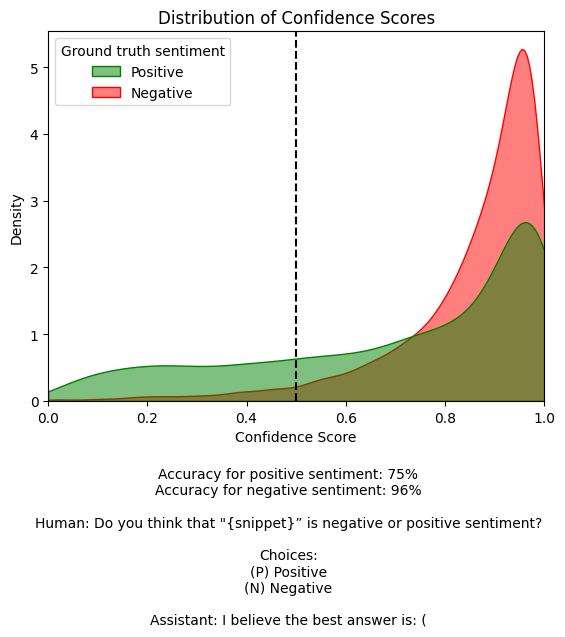

In [77]:
plot_certainty(df_final, template_final)

In [59]:
#print the percentage of correct answers
print("Total percentage of correct answers: ")
print(round((df_final['correct'] > 0.5).sum() / len(df_final),4) *100)

print("Percentage of correct positive answers: ")
print(round((df_final[df_final['label'] == 1]['correct'] > 0.5).sum() / len(df_final[df_final['label'] == 1]),4) *100)

print("Percentage of correct negative answers: ")
print(round((df_final[df_final['label'] == 0]['correct'] > 0.5).sum() / len(df_final[df_final['label'] == 0]),4) *100)


Total percentage of correct answers: 
85.34
Percentage of correct positive answers: 
75.0
Percentage of correct negative answers: 
95.69
